# USGS Water Use by County in 2015

### The [U.S. Geological Survey's National Water-Use Science Project](https://water.usgs.gov/watuse/), compiles and reports water-use data for the nation.

#### Water-Use reports and data are published at 5 year intervals starting in 1950. 
- The USGS published the most recent report [Estimated use of water in the United States in 2015](https://pubs.er.usgs.gov/publication/cir1441) in June, 2018. 
-  Along with this report, the USGS released [Estimated Use of Water in the United States County-Level Data for 2015](https://www.sciencebase.gov/catalog/item/get/5af3311be4b0da30c1b245d8). 

##### We will use this dataset to get a sense for public and private drinking water-use in Vermont at the county-scale and how it compares to the rest of the Continental United States.

In [1]:
# Load necessary libraries
import sciencebasepy
import pandas as pd
import requests
import io
import zipfile
import shapefile
from shapely.geometry import shape
import geopandas as gpd
import matplotlib.pyplot as plt

### Access relevant data
- The USGS Water Use data is posted on https://www.sciencebase.gov/catalog/
- This script accesses the dataset using the [sciencebasepy](https://github.com/usgs/sciencebasepy) module.

In [2]:
# Begin ScienceBase session
sb = sciencebasepy.SbSession()

# Dataset id found in ScienceBase url
dataset_id = '5af3311be4b0da30c1b245d8'

# This is a public item, no log in required.
item_json = sb.get_item(dataset_id)

# Find csv path in attached files
url = [file for file in item_json['files'] if 'csv' in file['name']][0]['url']

# Read csv into dataframe
water_use_2015 = pd.read_csv(url, header = 1)

Examine the water-use dataset

In [3]:
water_use_2015.head()

,STATE,STATEFIPS,COUNTY,COUNTYFIPS,FIPS,YEAR,TP-TotPop,PS-GWPop,PS-SWPop,PS-TOPop,...,TO-WGWTo,TO-WSWFr,TO-WSWSa,TO-WSWTo,TO-WFrTo,TO-WSaTo,TO-Wtotl,TO-CUsFrPartial,TO-CUsSaPartial,TO-CUTotPartial
0,AL,1,Autauga County,1,1001,2015,55.347,--,--,48.998,...,10.69,45.72,0.0,45.72,56.41,0.0,56.41,13.18,0.0,13.18
1,AL,1,Baldwin County,3,1003,2015,203.709,--,--,174.907,...,73.38,11.32,0.0,11.32,84.70,0.0,84.70,58.28,0.0,58.28
2,AL,1,Barbour County,5,1005,2015,26.489,--,--,24.587,...,6.06,2.96,0.0,2.96,9.02,0.0,9.02,2.96,0.0,2.96
3,AL,1,Bibb County,7,1007,2015,22.583,--,--,20.947,...,5.67,0.20,0.0,0.20,5.87,0.0,5.87,0.19,0.0,0.19
4,AL,1,Blount County,9,1009,2015,57.673,--,--,44.815,...,4.64,55.43,0.0,55.43,60.07,0.0,60.07,1.08,0.0,1.08


The column names in the water-use files are somewhat cryptic so we will also create a dictionary from the Data Dictionary in the excel file for reference

In [4]:
excel_url = [file for file in item_json['files'] if 'xlsx' in file['name']][0]['url']
water_use_dict = (pd.read_excel(excel_url, sheet_name = 'DataDictionary')).set_index('Column Tag').T.to_dict('list')

# View the first few keys and values in the data dictionary
list(water_use_dict.values())[0:12]

[['State postal abbreviation'],
 ['State FIPS code'],
 ['County name'],
 ['County FIPS code'],
 ['Concatenated State-county FIPS code'],
 ['Year of data=2015'],
 ['Total population of county, in thousands'],
 ['Public Supply, population served by groundwater, in thousands'],
 ['Public Supply, population served by surface water, in thousands'],
 ['Public Supply, total population served, in thousands'],
 ['Public Supply,  groundwater withdrawals, fresh, in Mgal/d'],
 ['Public Supply, groundwater withdrawals, saline, in Mgal/d']]

This dictionary provides reference to the full description for any column name abbreviation.

In [5]:
# Examine the full desciption of an abbreviation by accessing the value for any abbreviation (key)
water_use_dict['PS-WGWFr']

['Public Supply,  groundwater withdrawals, fresh, in Mgal/d']

### Use geopandas to create GeoDataFrame of US counties in 2015
The US Census hosts a zipped shapefile of [US counties in 2015.](http://www2.census.gov/geo/tiger/GENZ2015/shp/cb_2015_us_county_500k.zip) The code below is a modified set of steps from [agaidus/census_data_extraction](https://github.com/agaidus/census_data_extraction/blob/master/Reading_Zipped_Shapefiles.ipynb) which allows for processing this zipped shapefile into a geopandas GeoDataFrame without necessitating downloading the file.

- In the case that the url request to the Census url is not succesful a prompt will appear where the user can provide a local link to the downloaded shp file. To download the zip file click the url above. The request is sometimes unsuccesful if rapidly repeated.

In [6]:
# Read in shapefile from census
url = 'http://www2.census.gov/geo/tiger/GENZ2015/shp/cb_2015_us_county_500k.zip'
r = requests.get(url)

if not 'Service Unavailable' in str(r.content):
    z = zipfile.ZipFile(io.BytesIO(r.content))

    shp = io.BytesIO(z.read('cb_2015_us_county_500k.shp'))
    shx = io.BytesIO(z.read('cb_2015_us_county_500k.shx'))
    dbf = io.BytesIO(z.read('cb_2015_us_county_500k.dbf'))

    s = shapefile.Reader(shp=shp, shx=shx, dbf=dbf)

    attributes, geometry = [], []
    field_names = [field[0] for field in s.fields[1:]]  
    for row in s.shapeRecords():  
        geometry.append(shape(row.shape.__geo_interface__))  
        attributes.append(dict(zip(field_names, row.record)))
    
    proj4 = '+proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs'
    counties = gpd.GeoDataFrame(data = attributes, geometry = geometry, crs = proj4)
else:
    print('The connection to the url at the US Census did not work. Please download the file from the link above.')
    print('Paste file path. Example file path: /US_County_500k_2015/cb_2015_us_county_500k.shp')
    filepath = input('Enter the local file path:')
    counties = gpd.read_file(filepath)

### Join water-use data to counties geodataframe
In order to create a map that displays the water-use data from the [USGS report](https://www.sciencebase.gov/catalog/item/get/5af3311be4b0da30c1b245d8) it needs to be joined to the spatial data contained in the counties geodataframe.
- The join is based on the [County FIPS code](https://www.census.gov/geographies/reference-files/2015/demo/popest/2015-fips.html) which is contained in both datasets. Some slight alterations are needed to build the water-use County FIPS codes to match the format from the Census county shapefile.

In [7]:
# Convert FIPS to text in Water Use Dataframe, if only four characters add leading zero
water_use_2015['FIPS'] = water_use_2015['FIPS'].astype(str)
water_use_2015['FIPS'] = [('0' + a) if len(a) == 4 else a for a in water_use_2015['FIPS']]

# Join water-use dataframe to geodataframe using merge. 
# For the result to be a geodataframe the geodataframe has to be on the left
US_county_water_use = counties.merge(water_use_2015, how = 'left', left_on = 'GEOID', right_on = 'FIPS')

Examine the success of this join. Do all counties from the shapefile correspond to a county in the water-use dataset? Where are the counties that did not have a corresponding match?

In [8]:
not_joined = US_county_water_use[US_county_water_use['FIPS'].isnull()]
set(list(not_joined['STATEFP']))

{'60', '66', '69'}

The 'un-joined' counties are from American Samoa (60), Guam (66), and Commonwealth of the Northern Mariana Islands (69). We are going to focus only on the continental United States, so we will filter the dataframe to only include counties where the join was successful.

In [9]:
US_county_water_use = US_county_water_use[~US_county_water_use['FIPS'].isnull()]

### Preparing the Water-Use Data

The two water-use measurements I am most interested in at the moment are: 
- Percentage of Population served by Private Water Supplies
- Percentage of Population served by Public Water Supplies

These values are currently not in the dataset so they must be calculated before plotted. Remeber the populations in this dataset are in thousands.

In [10]:
# The relevant columns in the water-use dataset
columns = ['TP-TotPop', 'DO-SSPop', 'PS-TOPop']
# Print corresponding descriptions
for column in columns:
    print(column + ' = ' + str(water_use_dict[column]))

TP-TotPop = ['Total population of county, in thousands']
DO-SSPop = ['Domestic, self-supplied population, in thousands']
PS-TOPop = ['Public Supply, total population served, in thousands']


In [11]:
# Check that for all counties the drinking water for the entire population comes from only these two sources (Private or Public)
print(sum(round(US_county_water_use['DO-SSPop'] + US_county_water_use['PS-TOPop'] - US_county_water_use['TP-TotPop'], 3)))

0.0


In [12]:
# Calculate percentage of population served by private water supplies in each county
US_county_water_use['Per_Private'] = (US_county_water_use['DO-SSPop']/US_county_water_use['TP-TotPop'])*100

# Calculate percentage of population served by public water supplies in each county
US_county_water_use['Per_Public'] = (US_county_water_use['PS-TOPop']/US_county_water_use['TP-TotPop'])*100

# Update dictionary with new column abbreviations and descriptions
water_use_dict['Per_Private'] = "['Percentage of Population served by private water supplies']"
water_use_dict['Per_Public'] = "['Percentage of Population served by public water supplies']"

## Mapping
### Coordinate Systems
When creating a map and using spatial data it is important to think about the coordinate reference system (crs) of your data and what crs you want to use. 
One of my favorite resources for crs and projections is [epsg.io](http://epsg.io).

In this case we are focused on simple visualizations of the Water-Use dataset for the Continental US and Vermont. 
- For the map of the entire Continental United States the US_county_water_use geodataframe is converted from the [NAD83](http://epsg.io/4269) coordinate system to [North America Lambert Conformal Conic](https://epsg.io/102009) using a projection string.


- We also define the projection string for [Vermont State Plane NAD83 (Feet)](https://epsg.io/102745) for later use plotting Vermont county data

In [13]:
# Print the coordinate reference system of the US_county_water_use geodataframe
print('Initial Coordinate System = ' + str(US_county_water_use.crs))

# From epsg.io we know this is the Geodetic coordinate system NAD83

US_county_water_use = US_county_water_use.to_crs("+proj=lcc +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96" 
                                                 "+x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs")
print('\nNew Coordinate System = ' + US_county_water_use.crs)

VT_SP_NAD83_Feet_proj_str = ('+proj=tmerc +lat_0=42.5 +lon_0=-72.5 '
                            '+k=0.9999642857142857 +x_0=500000.0000000002 +y_0=0 '
                            '+ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs')
print('\nVermont State Plane Coordinate System Projection String = ' + VT_SP_NAD83_Feet_proj_str)

Initial Coordinate System = +proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs

New Coordinate System = +proj=lcc +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96+x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs

Vermont State Plane Coordinate System Projection String = +proj=tmerc +lat_0=42.5 +lon_0=-72.5 +k=0.9999642857142857 +x_0=500000.0000000002 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs


### Creating Figures
#### Figures 1 and 2
The first set of figures will be a map of the continental US and a map of Vermont. Both maps will be chloropleth maps with shades of blue representing the Percentage of the Population in each county served by either private or public supplies.

In [14]:
# Remove Alaska, Hawaii, Puerto Rico, and US Virgin Islands
remove_regions = ['02', '15', '72', '78']
US_county_water_use = US_county_water_use.loc[~(US_county_water_use['STATEFP'].isin(remove_regions))]

# Filter for Vermont counties
Vermont_water_use_2015 = US_county_water_use.loc[US_county_water_use['STATE'] == 'VT'].copy()

In [15]:
# Setup outlines for Continental US and Vermont
# Dissolve geodataframe to single geometry called Con_US_Outline
US_county_water_use['Dissolve'] = 1
Con_US_Outline = US_county_water_use.dissolve('Dissolve')

# Dissolve Vermont geodataframe to single geometry in the two crs's
Vermont_water_use_2015['Dissolve'] = 1
VT_NALCC = Vermont_water_use_2015.dissolve('Dissolve')
VT = VT_NALCC.to_crs(VT_SP_NAD83_Feet_proj_str).copy()

Use [matplotlib](https://matplotlib.org/) to generate first figure

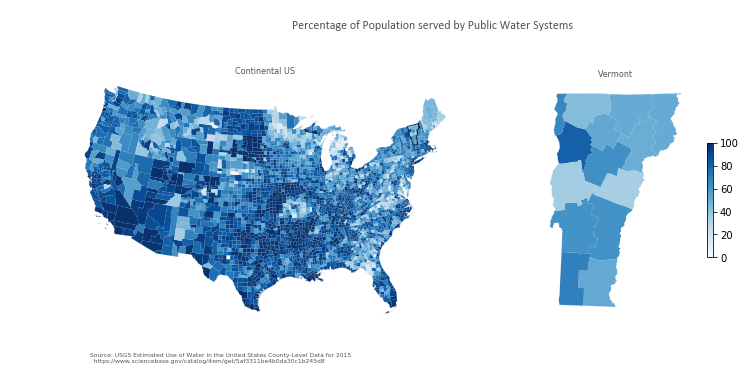

In [16]:
# Create Figure and subplots
plt.rcParams['figure.figsize'] = 12, 6
fig = plt.figure()

ax1 = plt.subplot2grid((10,10), (0,0), rowspan = 10, colspan = 6)
ax2 = plt.subplot2grid((10,10), (0, 7), rowspan = 10, colspan = 3)
ax1.set_aspect('equal')
ax2.set_aspect('equal')

# Set the max and min of the color ramp and allow it to be repeated over multple plots
vmin, vmax = 0, 100     

# Plot Chloropleth map of water use by county for continental US on ax1
US_county_water_use.plot(column = 'Per_Public', ax = ax1, cmap = 'Blues', linewidth = 0, vmin = vmin, vmax = vmax)

# Plot outline of Continental US
Con_US_Outline.plot(ax = ax1, facecolor="none", edgecolor = '#bfbfbf', linewidth = 0.05)
# Plot VT outline
VT_NALCC.plot(ax = ax1, facecolor="none", edgecolor = '#000000', linewidth = .65)

# Plot Chloropleth map of water use by county for vermont on ax2
# Reproject Vermont geometry to Vermont State Plane 1983 Feet
Vermont_water_use_2015 = Vermont_water_use_2015.to_crs(VT_SP_NAD83_Feet_proj_str)

# Plot Vermont chloropleth and Vermont state outline on ax2
Vermont_water_use_2015.plot(column = 'Per_Public', ax = ax2, cmap = 'Blues', linewidth = 0, vmin = vmin, vmax = vmax)
VT.plot(ax = ax2, facecolor = 'none', edgecolor = '#bfbfbf', linewidth = 0.05)

# Remove axis
ax1.axis('off')
ax2.axis('off')

# Add annotation
ax1.set_title('Continental US', fontdict={'fontsize': '7', 'fontweight' : '1'},  color='#555555', pad = 0.5, fontsize=8)
ax2.set_title('Vermont', fontdict={'fontsize': '7', 'fontweight' : '1'},  color='#555555', fontsize=8)
ax1.annotate('Source: USGS Estimated Use of Water in the United States County-Level Data for 2015\n  '
             'https://www.sciencebase.gov/catalog/item/get/5af3311be4b0da30c1b245d8', xy=(0.12, 0.10),  
             xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=6, color='#555555')
ax1.annotate('Percentage of Population served by Public Water Systems', xy=(0.58, 0.95),  
             xycoords='figure fraction', horizontalalignment='center', verticalalignment='top', fontsize=12, fontname = 'calibri',color='#555555')
                    
# Create colorbar
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# Empty array for the data range
sm._A = []

# Add the colorbar to the figure
cbar = fig.colorbar(sm, orientation = 'vertical', shrink = 0.35, pad = 0.1)

Create a second figure showing the Percentage of the Population in each county served by Private Water Systems

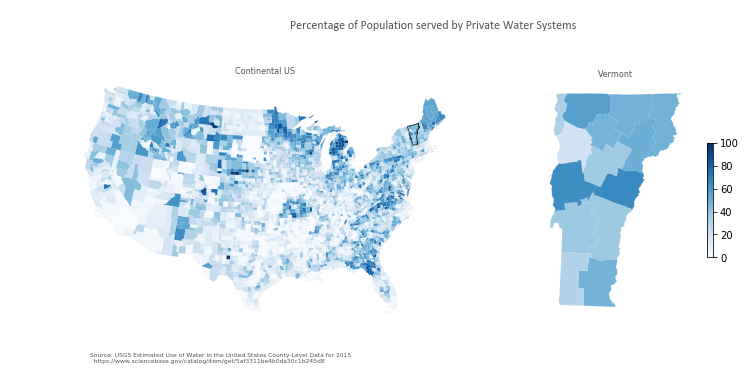

In [17]:
fig2 = plt.figure()

ax1 = plt.subplot2grid((10,10), (0,0), rowspan = 10, colspan = 6)
ax2 = plt.subplot2grid((10,10), (0, 7), rowspan = 10, colspan = 3)
ax1.set_aspect('equal')
ax2.set_aspect('equal')

# Plot Chloropleth map of water use by county for continental US on ax1
US_county_water_use.plot(column = 'Per_Private', ax = ax1, cmap = 'Blues', linewidth = 0, vmin = vmin, vmax = vmax)
Con_US_Outline.plot(ax = ax1, facecolor="none", edgecolor = '#bfbfbf', linewidth = 0.05)
VT_NALCC.plot(ax = ax1, facecolor="none", edgecolor = '#000000', linewidth = .65)

Vermont_water_use_2015.plot(column = 'Per_Private', ax = ax2, cmap = 'Blues', linewidth = 0, vmin = vmin, vmax = vmax)
VT.plot(ax = ax2, facecolor = 'none', edgecolor = '#bfbfbf', linewidth = 0.05)

# Remove axis
ax1.axis('off')
ax2.axis('off')

# Add annotation
ax1.set_title('Continental US', fontdict={'fontsize': '7', 'fontweight' : '1'},  color='#555555', pad = 0.5, fontsize=8)
ax2.set_title('Vermont', fontdict={'fontsize': '7', 'fontweight' : '1'},  color='#555555', fontsize=8)
ax1.annotate('Source: USGS Estimated Use of Water in the United States County-Level Data for 2015\n  '
             'https://www.sciencebase.gov/catalog/item/get/5af3311be4b0da30c1b245d8', xy=(0.12, 0.10),  
             xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=6, color='#555555')
ax1.annotate('Percentage of Population served by Private Water Systems', xy=(0.58, 0.95),  
             xycoords='figure fraction', horizontalalignment='center', verticalalignment='top', fontsize=12, fontname = 'calibri',color='#555555')
                    
# Create colorbar
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# Empty array for the data range
sm._A = []

# Add the colorbar to the figure
cbar = fig2.colorbar(sm, orientation = 'vertical', shrink = 0.35, pad = 0.1)

#### Figure 3
An additional map that compares the percentage of the population in each Vermont county that use private and public water systems. 
- This map will use labels to display the corresponding values for each Vermont county.

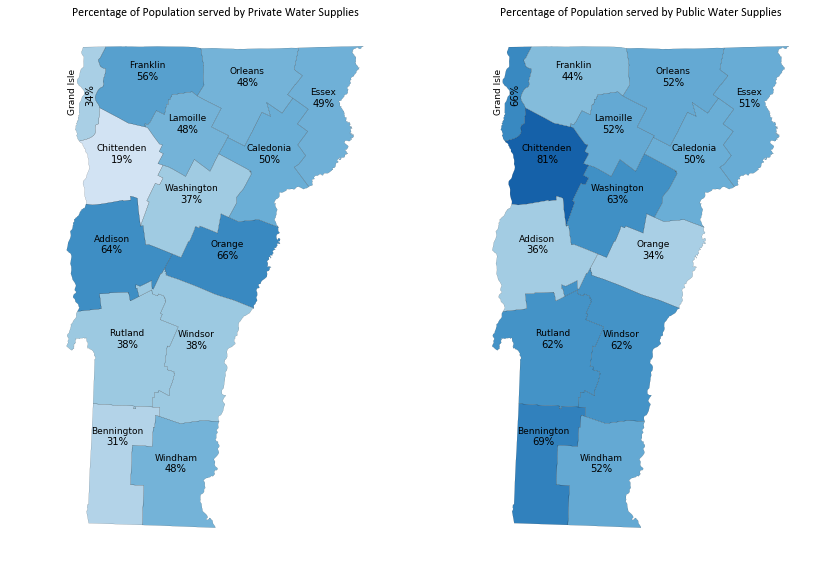

In [32]:
plt.rcParams['figure.figsize'] = 15, 15
fig3 = plt.figure()

ax1 = plt.subplot2grid((10,10), (0, 0), rowspan = 10, colspan = 4)
ax2 = plt.subplot2grid((10,10), (0, 5), rowspan = 10, colspan = 4)
ax1.set_aspect('equal')
ax2.set_aspect('equal')
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Percentage of Population served by Private Water Supplies', fontname = 'calibri')
ax2.set_title('Percentage of Population served by Public Water Supplies', fontname = 'calibri')


Vermont_water_use_2015.plot(column = 'Per_Private', ax = ax1, cmap = 'Blues', linewidth = 5, vmin = vmin, vmax = vmax)
Vermont_water_use_2015.plot(ax = ax1, facecolor = 'none', edgecolor = 'black', linewidth = .1)

Vermont_water_use_2015.plot(column = 'Per_Public', ax = ax2, cmap = 'Blues', linewidth = 5, vmin = vmin, vmax = vmax)
Vermont_water_use_2015.plot(ax = ax2, facecolor = 'none', edgecolor = 'black', linewidth = .1)

# Use the geopandas method centroid to create coordinates for label placement
# Round the values to the nearest tenth of a percent
Vermont_water_use_2015['Per_Private'] = Vermont_water_use_2015['Per_Private'].round().astype('int')
Vermont_water_use_2015['Per_Public'] = Vermont_water_use_2015['Per_Public'].round().astype('int')

# Add annotations/labels

# Dictionaries for county and percent label rotation and offset
label_rot = dict(zip(Vermont_water_use_2015['NAME'],[0] * len(Vermont_water_use_2015)))
label_rot['Grand Isle'] = 90

vertical_county_label_offset = 25000
horizontal_county_label_offset = -30000

vertical_label_offset = dict(zip(Vermont_water_use_2015['NAME'],[vertical_county_label_offset] * len(Vermont_water_use_2015)))
vertical_label_offset['Grand Isle'] = 0
vertical_label_offset['Bennington'] = 55000
horizontal_label_offset = dict(zip(Vermont_water_use_2015['NAME'],[0] * len(Vermont_water_use_2015)))
horizontal_label_offset['Grand Isle'] = horizontal_county_label_offset

vertical_per_offset = dict(zip(Vermont_water_use_2015['NAME'],[0] * len(Vermont_water_use_2015)))
vertical_per_offset['Grand Isle'] = 0
vertical_per_offset['Bennington'] = 30000

# County Names
Vermont_water_use_2015.apply(lambda x: ax1.annotate(s=(str(x.NAME)), 
                                                    xy=x.geometry.centroid.coords[0], 
                                                    xytext=((x.geometry.centroid.coords[0][0] + horizontal_label_offset[x.NAME]),
                                                            (x.geometry.centroid.coords[0][1] + vertical_label_offset[x.NAME])),
                                                    rotation = label_rot[x.NAME], fontsize = 9,
                                                    ha='center', va = 'center'), axis=1);

Vermont_water_use_2015.apply(lambda x: ax2.annotate(s=(str(x.NAME)), 
                                                    xy=x.geometry.centroid.coords[0], 
                                                    xytext=((x.geometry.centroid.coords[0][0] + horizontal_label_offset[x.NAME]),
                                                            (x.geometry.centroid.coords[0][1] + vertical_label_offset[x.NAME])),
                                                    rotation = label_rot[x.NAME], fontsize = 9,
                                                    ha='center', va = 'center'), axis=1);
# Percentage Labels
Vermont_water_use_2015.apply(lambda x: ax1.annotate(s=(str(x.Per_Private) + '%'), 
                                                    xy=x.geometry.centroid.coords[0],
                                                    xytext=((x.geometry.centroid.coords[0][0]),
                                                            (x.geometry.centroid.coords[0][1] + vertical_per_offset[x.NAME])),
                                                    rotation = label_rot[x.NAME],
                                                    ha='center'), axis=1);

Vermont_water_use_2015.apply(lambda x: ax2.annotate(s=((str(x.Per_Public)) + '%'), 
                                                    xy=x.geometry.centroid.coords[0], 
                                                    xytext=((x.geometry.centroid.coords[0][0]),
                                                            (x.geometry.centroid.coords[0][1] + vertical_per_offset[x.NAME])),
                                                    rotation = label_rot[x.NAME],
                                                    ha='center'), axis=1);
plt.savefig(r"C:\Users\colin.dowey\OneDrive - State of Vermont\MyFiles\USGSWaterData\VCGI_Medium\Figures\fig3.pdf")

## State-Level estimates 
Above we selected the counties of Vermont into the Vermont_water_use_2015 dataframe. We can use this dataframe to calculate the estimated percentage of Vermonters that rely on private and public supplies for drinking water.

In [19]:
# Use the dictionary to confirm the fields of interest
print(water_use_dict['DO-SSPop'])
print(water_use_dict['PS-TOPop'])
print(water_use_dict['TP-TotPop'])

['Domestic, self-supplied population, in thousands']
['Public Supply, total population served, in thousands']
['Total population of county, in thousands']


In [20]:
# Calculate Statewide values
VT_pop = sum(Vermont_water_use_2015['TP-TotPop'])*1000
VT_pub = sum(Vermont_water_use_2015['PS-TOPop'])*1000
VT_priv = sum(Vermont_water_use_2015['DO-SSPop'])*1000

# Calculate Statewide percentages
P_Pub = VT_pub/VT_pop
P_Priv = VT_priv/VT_pop

# Print with string formatting...
print("Approximate Percentage of Vermonters served by Public Water Supplies = {0:.0%}".format(P_Pub))
print("Approximate Percentage of Vermonters served by Private Water Supplies = {0:.0%}".format(P_Priv))

Approximate Percentage of Vermonters served by Public Water Supplies = 61%
Approximate Percentage of Vermonters served by Private Water Supplies = 39%


#### This is a relatively large percentage of Vermonters that rely on private water systems. What are the common sources for this drinking water?

If we examine the information in this dataset there are two fields that will provide some insight.

In [21]:
print(water_use_dict['DO-WGWFr'])
print(water_use_dict['DO-WSWFr'])

['Domestic, self-supplied groundwater withdrawals, fresh, in Mgal/d']
['Domestic, self-supplied surface-water withdrawals, fresh, in Mgal/d']


Using the estimated values in the fields above, we can determine approximately how much water is withdrawn for private water supplies from surface-water or groundwater.

In [22]:
DO_GW_Mgal = sum(Vermont_water_use_2015['DO-WGWFr'])
DO_SW_Mgal = sum(Vermont_water_use_2015['DO-WSWFr'])
print('Statewide estimate for Domestic, self-supplied groundwater withdrawals = ' + str(DO_GW_Mgal) + ' Mgal/d')
print('Statewide estimate for Domestic, self-supplied surface-water withdrawals = ' + str(DO_SW_Mgal) + ' Mgal/d')

Statewide estimate for Domestic, self-supplied groundwater withdrawals = 10.96 Mgal/d
Statewide estimate for Domestic, self-supplied surface-water withdrawals = 0.0 Mgal/d
